Airbnb is a site primarily used for vacation rentals; in its rawest form, its a marketplace allowing clients (hosts) to access customers (renters?). So while this data is primarily about the product (the rooms), I want to explore more the side of what information we can attempt to gather about the people on the marketplace. Below I outline some questions which I would like to propose to help us make inferences about the people.

- How does the name change with gender of the host? a riskier question would be how it changes by ethnicity of the host.
- Could we try and profile host? We have first names which tells us a surprising amount about the host. We can make educated guesses about ethnicities, ages, region of birth among other things.
- Based on the price of the room, room_type, and availability_365, we can make some guesses about the wealth of the person too. No one here is crazy loaded or they wouldn't be on Airbnb, but theres defintiely some inferences we can make about the wealth of the person.
- We can make the assumption that reviews_per_month\*minimum_nights is correlated with stays per month, which may or may not be valid. In this case though, we can try and make guess about who (i.e for what purposes) is using the site in New York city. This is a super rich question in my opinion. This is because we can try and look at locations and other factors to see what the places that are most frequented have in common. We could pull in outside data such as subway stations and tourism spots as well as business locations (maybe) to allow us to make use of the geo-coordinates.

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gender_guesser.detector as gender
import requests
from bs4 import BeautifulSoup

import re
from shapely.geometry import Point

import geopandas as gpd
from shapely import wkt

from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

pd.set_option("display.max_rows", None)

In [531]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")

In [530]:
a=0
for i in range(1,11):
    counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
    counts=counts.loc[counts.price>50]
    c=data_set#.loc[data_set.room_type=="Private room"]
    d=c[["NTAName","availability_365",f"Age{i}"]].groupby(["NTAName"]).mean()#/counts*counts

    d=d.loc[d.availability_365==d.availability_365]
    d = pd.merge(counts, d, how='inner',on='NTAName')

    a+=d[["availability_365",f"Age{i}"]].corr().iloc[0::2,-1]
print(a/10)
#true_count = neighbourhoods.merge(d, on='NTAName')
#true_count.plot(column='availability_365',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
#plt.title("Mean Average Availability")

availability_365    0.438188
Name: Age1, dtype: float64


In [493]:
data_set=data_set.drop_duplicates(subset = ["longitude","latitude"])
#len(data_set.loc[(data_set.room_type=="Shared room") & (data_set.calculated_host_listings_count==1)])/len(data_set.loc[data_set.calculated_host_listings_count==1])

len(data_set.loc[(data_set.room_type=="Shared room") & (data_set.calculated_host_listings_count>1)])#/len(data_set.loc[data_set.calculated_host_listings_count>1])
#data_set.loc[(data_set.room_type=="Shared room") & (data_set.calculated_host_listings_count>1)].groupby(['host_id']).head()

175

In [475]:
count=0
c2=0
sentence_list = data_set.name.tolist()
print(re.split('\s', sentence_list[0]))
for sentence in sentence_list:
    if sentence==sentence:
        for word in re.split('\s', sentence): # split with whitespace
            c2+=1
            if word=="subway" or word=="Subway":
                count += 1
print( count/c2)

['Clean', '&', 'quiet', 'apt', 'home', 'by', 'the', 'park']
0.002269611171012872


In [532]:
data_set.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'gender', 'nearest_subway_station', 'Age1', 'Age2',
       'Age3', 'Age4', 'Age5', 'Age6', 'Age7', 'Age8', 'Age9', 'Age10',
       'Decade1', 'Decade2', 'Decade3', 'Decade4', 'Decade5', 'Decade6',
       'Decade7', 'Decade8', 'Decade9', 'Decade10'],
      dtype='object')

In [534]:
data_set[["price","nearest_subway_station"]].corr()#.iloc[0::2,-1]

,price,nearest_subway_station
price,1.000000,-0.034912
nearest_subway_station,-0.034912,1.000000


In [157]:
data_set.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,Decade1,Decade2,Decade3,Decade4,Decade5,Decade6,Decade7,Decade8,Decade9,Decade10
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,40s,90s,60s,90s,50s,70s,40s,40s,40s,50s
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,60s,80s,80s,70s,90s,70s,90s,80s,60s,60s
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,40s,80s,70s,80s,90s,90s,100s,50s,50s,100s
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,50s,80s,60s,50s,60s,50s,60s,90s,80s,80s


How to infer age of person from name? Social security lets us download baby names by year going back to 1880. For each host name, we can look at the name and see its distribution over the years (we can do a hard cutoff at 1930 and make the assumption no one older than 90 is an airbnb host). This doesn't give a hard answer, but instead just a distribution. There are at several options to proceed here; first, we could just say a distribution is good enough and then continue the analysis. Another option would be to assign the person to their most likely birth year (or decade, not sure how we'll do this yet). One other possibility is to only analyze names that are distinctly from a certain time window. One last option, which we will utilize, is to choose a year randomly from the empirical distribution provided by the dataset. This is known as a Monte Carlo simulation, and it relies on the fact that it will become accurate over  a sufficiently large data set. In our case, this method may break down when we choose to analyze by neighborhood, since many of the neighborhoods have very few AirBnBs. One thing we will do to try and migitate the effect is to draw multiple times from the distribution for each person. We will do this 10 times, effectively giving us 10 times the data. This still will not fully make up for the lack of data in some cases, but it is the best we can do.

Assumptions:
- The data we have only list names with more than 5 occurences, so we will be making the assumption that the proportion of names that have less than 5 occurences for each year is the same across the years of data.
- No one older than 90 or younger than 18 is a host (1930-2003)
- Uniform prior distribution, that is we are not assuming any prior knowledge about the ages of hosts.
- No one has died. Could weight younger ages more heavily since less of them have died.

In [105]:
names=pd.DataFrame()
for year in range(1930,2003):
    current_year=pd.read_csv(f"names/yob{year}.txt",header=None)
    current_year.columns=["Name","Gender","Count"]
    current_year['Year']=year
    names = pd.concat([names, current_year])

In [106]:
names.head()

,Name,Gender,Count,Year
0,Mary,F,64147,1930
1,Betty,F,38236,1930
2,Dorothy,F,30409,1930
3,Helen,F,19912,1930
4,Margaret,F,18354,1930


In [122]:
def year(name,n):
    temp=names.loc[names.Name==name]
    if len(temp):
        N=temp.Count.sum()
        probs=temp.groupby(['Year']).sum().Count/N
        choice=np.random.choice(a=temp.Year.unique(),p=probs,size=n)
        #mu=(temp.Count*temp.Year).sum()/N
        #sigma=((temp.Count*(temp.Year-mu)**2).sum()/N)**.5
        return (2020-choice).tolist()
    else:
        return [float('NaN')]*n

In [112]:
#Function to give decade of birth given 
def give_decade(age):
    if age==age:
        decade=int(((120-age)//10) * 10)
        return f"{decade}s"
    else:
        return "NA"

In [124]:
ages=[year(name,10) for name in data_set['host_name']]
decades=[[give_decade(ag) for ag in age] for age in ages]

In [127]:
decades=pd.DataFrame(decades,columns=['Decade1','Decade2','Decade3','Decade4','Decade5','Decade6','Decade7','Decade8','Decade9','Decade10'])
ages=pd.DataFrame(ages,columns=['Age1','Age2','Age3','Age4','Age5','Age6','Age7','Age8','Age9','Age10'])

In [129]:
ages.head()

,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Age8,Age9,Age10
0,73.0,23.0,54.0,26.0,62.0,50.0,77.0,79.0,78.0,65.0
1,58.0,32.0,31.0,43.0,28.0,46.0,23.0,40.0,59.0,59.0
2,76.0,34.0,41.0,31.0,25.0,22.0,20.0,64.0,63.0,19.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,64.0,31.0,53.0,65.0,58.0,67.0,60.0,30.0,40.0,32.0


In [136]:
data_set = pd.concat([data_set, ages,decades], axis=1)

In [139]:
#data_set.to_csv("Airbnb_NYC_2019.csv",index=False)

There are some huge holes in our methods for selecting names. Namely, we did not consider how to weight the different age groups. Consider this, older ages are less likely to still be alive, but we only look at birthing data, so older people are represented at a higher percentage of time. In addition, with immigration, certain ethinicities may have more overall births in more recent times, simply because the parents may have immigrated and so are not incorporated into the data. However, we will make one more blanket assumption, that these factors effect all neighborhoods equally, since what we are looking for is differences in the neighborhoods rather than their raw values. Again this might not be true due to ethnic heterogeneity spatially, leaving some areas more effected than others by the effects of immigration outlined above.

In [ ]:
#ownership=[38.5]*16+[61]*10+[69.8]*10+[76]*10+[80.2]*25

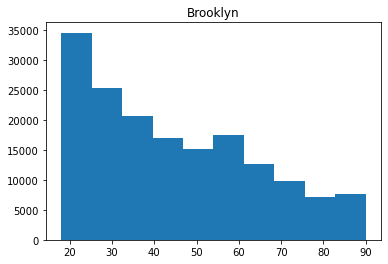

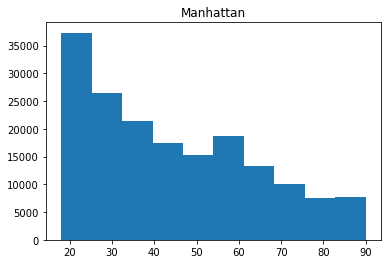

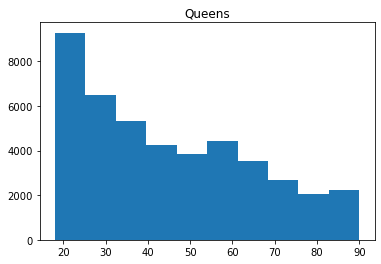

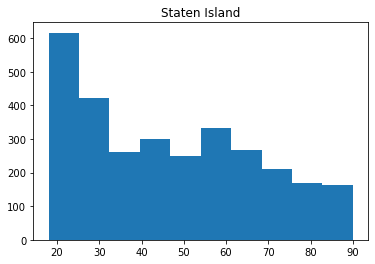

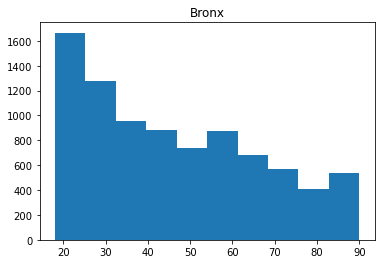

In [164]:
for n in data_set["neighbourhood_group"].unique():
    old=[]
    temp=data_set.loc[data_set.neighbourhood_group==n]
    for i in range(1,11):
        old+=temp[f"Age{i}"].tolist()
    plt.figure()
    plt.hist(old)
    plt.title(f"{n}")

The biggest takeaway from the above is that the hosts are suprisingly young. So much so that we looked to verify this from other sources. From web browsing, the best we were able to find was that in Europe, 36% of hosts are 25-34, and 15% were younger than 25 (https://capitalcounselor.com/airbnb-statistics/#:~:text=European%20Airbnb%20host%20demographics%20data,and%2034%20years%20of%20age.&text=36%25%20of%20the%20Airbnb%20hosts,(18%E2%80%9325%20years)). While these aren't NYC statistics, it does give us some reassurance that our method is somewhat accurate. Our hypothesis is that this is being driven by younger people both looking to make ends meet as well as young people utilizing their parents properties to generate income for themselves.

One other interseting thing to note is the consistent bump again around age 55-60.

In [3]:
pd.crosstab(data_set.Decade1, data_set.neighbourhood)
#sns.set(rc={'figure.figsize':(15,2)})
#sns.heatmap(pd.crosstab(data_set.Decade1, data_set.neighbourhood,normalize="columns"))

neighbourhood,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",...,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside
Decade1,,,,,,,,,,,,,,,,,,,,,
100s,4,1,2,0,75,1,7,9,0,1,...,0,0,3,321,0,12,3,0,0,33
30s,1,0,0,3,31,1,4,11,0,0,...,0,1,1,187,0,5,4,0,0,8
40s,6,0,2,6,53,0,3,7,1,0,...,0,1,1,220,0,11,8,2,0,4
50s,5,0,0,6,65,1,7,8,1,0,...,0,2,2,330,0,25,10,1,0,11
60s,4,0,2,11,77,2,8,18,1,0,...,1,1,2,468,1,12,12,0,1,12
70s,6,1,2,18,117,3,5,15,1,0,...,0,0,6,453,0,16,8,1,0,25
80s,5,1,2,9,136,1,7,13,0,0,...,1,3,6,614,0,24,9,1,0,36
90s,5,1,2,14,182,7,15,31,2,1,...,0,3,7,814,0,30,11,3,0,55


From the above, there doesn't seem to be any trend with regards to our predicted host age and neighborbood. It doesn't make sense for us to look at the individual neighborhoods (as opposed to the groups) because our analysis relies on our age predictions being amorized over large amounts of data. However, the indiivudal neighborhoods often have very few observations making any analysis pointless as any results derived would be without evidence backing them.

In [ ]:
old=[]
    temp=data_set.loc[data_set.neighbourhood_group==n]
    for i in range(1,11):
        old+=temp[f"Age{i}"].tolist()

In [461]:
t_data_set=data_set.loc[data_set.price<1000]
t_data_set=t_data_set.loc[t_data_set.Age1==t_data_set.Age1] #remove NaN

Text(0, 0.5, 'Listing Price')

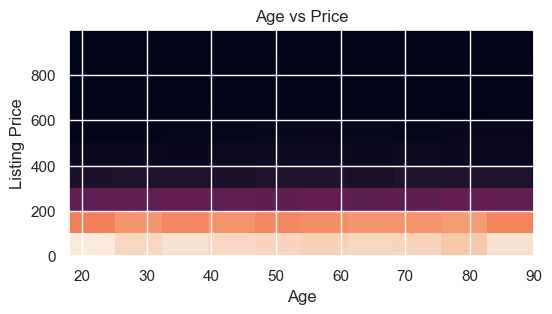

In [464]:
heatmap,xedges, yedges=np.histogram2d(t_data_set['Age1'], t_data_set['price'])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap=(heatmap.T/heatmap.sum(1)).T
plt.figure(figsize=(6, 3), dpi=100)
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")
plt.title("Age vs Price")
plt.xlabel("Age")
plt.ylabel("Listing Price")


Even though we see more younger folk hosting AirBnBs, there is no difference in the value of the properties they rent. In fact, there does not appear to be an effect of price and age at all.

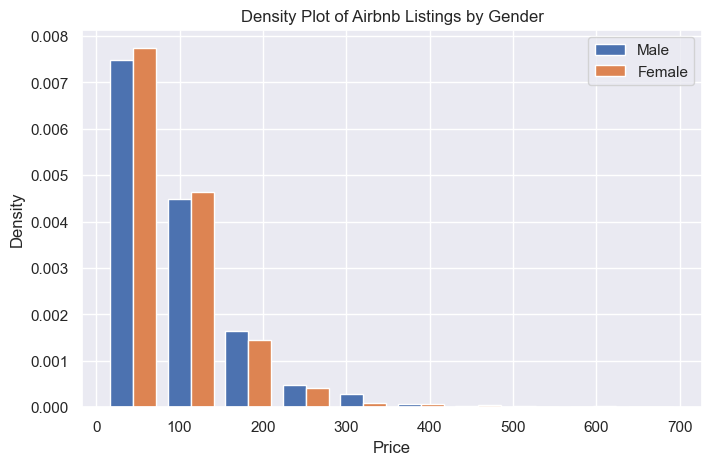

In [266]:
#d = gender.Detector()
#data_set['gender']=[d.get_gender(name) for name in data_set['host_name']]
men=np.array(data_set['price'].loc[(data_set.price<750)&(data_set.gender=="male")].tolist())
women=np.array(data_set['price'].loc[(data_set.price<750)&(data_set.gender=="female")].tolist())
plt.figure(figsize=(8, 5), dpi=100)
plt.hist([men,women], density=True, histtype='bar')#, color=colors, label=colors)
plt.legend(["Male","Female"])
plt.title("Density Plot of Airbnb Listings by Gender")
plt.xlabel("Price")
plt.ylabel("Density")
plt.show()

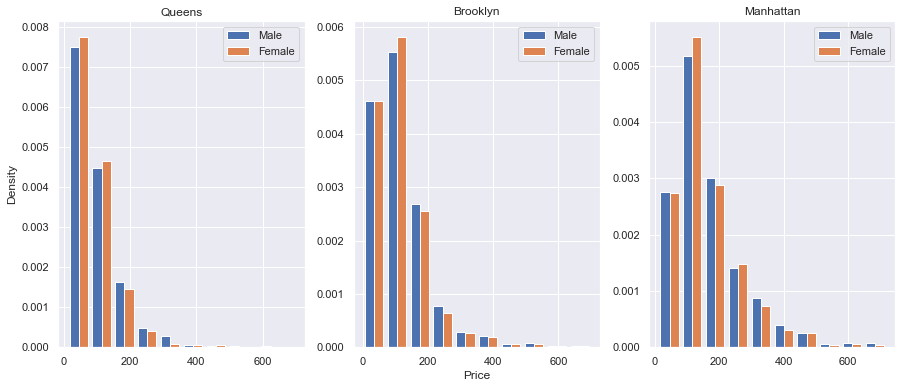

<Figure size 800x500 with 0 Axes>

In [283]:
f, (ax2, ax3,ax4) = plt.subplots(nrows=1, ncols=3)
f.set_figheight(6)
f.set_figwidth(15)
plt.figure(figsize=(8, 5), dpi=100)
for j,k in enumerate([ax2, ax3,ax4]):
    i=["Queens","Brooklyn","Manhattan"][j]
    data_set=pd.read_csv("Airbnb_NYC_2019.csv")
    data_set=data_set.loc[(data_set.neighbourhood_group==i)]
    men=np.array(data_set['price'].loc[(data_set.price<750)&(data_set.gender=="male")].tolist())
    women=np.array(data_set['price'].loc[(data_set.price<750)&(data_set.gender=="female")].tolist())
    k.hist([men,women], density=True, histtype='bar')#, color=colors, label=colors)
    k.legend(["Male","Female"])
    k.title.set_text(f"{i}")
ax3.set_xlabel("Price")
ax2.set_ylabel("Density")
data_set=pd.read_csv("Airbnb_NYC_2019.csv")

(0.0, 0.006)

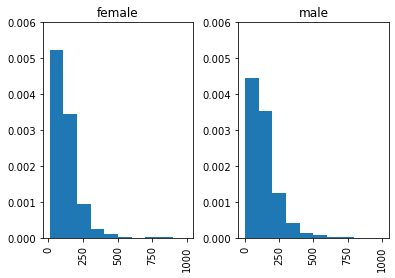

In [12]:
ax_list=data_set['price'].loc[(data_set.price<1000) & ((data_set.gender=="male") | (data_set.gender=="female"))].hist(by=data_set["gender"],density=True)

ax_list[0].set_ylim((0,.006))
ax_list[1].set_ylim((0,.006))

Interestingly, when we assigned genders to names via the python gender-guesser package, we found that the distributions between male and female airbnb properties with respect to price differed significantly. For this analysis, we chose to only look at names that the package was confident were male or female, avoiding ambiguous names. We plotted the density function, avoiding misleading plots due to the larger number of women hosts in the data set. Overall, there was a higher proportion of women hosts at the lower price ranges (<144$), but at the higher price ranges a lower proportion of the hosts were women compared to the men. It is apparent that there is some difference; however, we wanted to check to see if there was any confounding factor causing this, and that maybe some other variable is driving this difference, namely the type of unit

<BarContainer object of 4 artists>

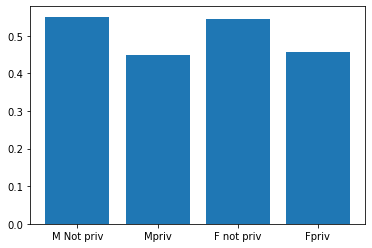

In [15]:
Nmale=len(data_set['price'].loc[(data_set.gender=="male")])
Nfemale=len(data_set['price'].loc[(data_set.gender=="female")])
data=[len(data_set['price'].loc[(data_set.room_type!="Private room") & (data_set.gender=="male")])/Nmale,len(data_set['price'].loc[(data_set.room_type=="Private room") & (data_set.gender=="male")])/Nmale,
      len(data_set['price'].loc[(data_set.room_type!="Private room") & (data_set.gender=="female")])/Nfemale,len(data_set['price'].loc[(data_set.room_type=="Private room") & (data_set.gender=="female")])/Nfemale]
plt.bar(["M Not priv","Mpriv","F not priv","Fpriv"],data)

It seems that there is no correlation between the room type and gender, which suggest likely the gender of the host is having an affect directly on the price, and that it could be associated with men making more money in general and thus possibly owning nicer properties. However, it is impossible to make conclusions because of the limited data provided and the possible confounding factors. One would imagine that not all couples post their properties together, and instead one of them posts for the couple. Is is more likely for the male (assuming a heterosexual couple) partner to post or for the female to post? And do couples like this generally demand more for their properties?

One other question we would like to ask now that we have noticed an effect of the hosts gender on the price, but does that effect cause downstream ripples. For instance with respect to neighborhood, do more men host in the certain pricier neighborhoods, or is the man-woman ration similar across all boroughs, just the men tend to host pricier properties across all boroughs. To analyze this, we can look at a boxplot incorportating geneder across neighborhoods.

In [261]:
t_data_set=data_set.loc[(data_set.gender=="male") | (data_set.gender=="female")]
t_data_set=t_data_set.drop_duplicates(subset = ["host_id"])
counts=t_data_set[['gender',"neighbourhood_group","price"]].groupby(['gender',"neighbourhood_group"]).count()

wcounts=counts["price"][0:5]/sum(counts["price"][0:5])
mcounts=counts["price"][5:10]/sum(counts["price"][5:10])
for i in range(5):
    n=wcounts[i]+mcounts[i]
    wcounts[i]=wcounts[i]/n
    mcounts[i]=mcounts[i]/n

counts.columns=["Count"]
wcounts#/sum(mcounts)

gender  neighbourhood_group
female  Bronx                  0.473353
        Brooklyn               0.525540
        Manhattan              0.473992
        Queens                 0.511462
        Staten Island          0.514312
Name: price, dtype: float64

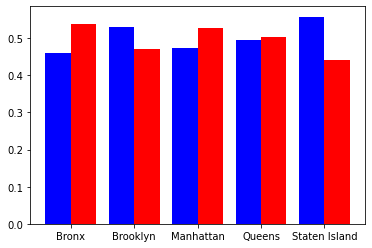

In [17]:
# data_set=data_set.loc[(data_set.gender=="male") | (data_set.gender=="female")]
# sns.set(rc={'figure.figsize':(15,2)})
# sns.heatmap(pd.crosstab(data_set.gender, data_set.neighbourhood_group,normalize="columns"))

x = np.arange(5)

w = 0.2
plt.bar(x-w, wcounts, width=2*w, color='b', align='center')
plt.bar(x+w, mcounts, width=2*w, color='r', align='center')
# ax.xaxis_date()
# ax.autoscale(tight=True)
plt.xticks(list(range(5)), ["Bronx","Brooklyn","Manhattan","Queens","Staten Island"])
plt.show()

The above graph incidate that men tend to be host more often in Statent Island and Brooklyn, while men tend to more often in the Bronx and Manhattan. However, due to the distribution of samples, the sample sizes for Staten Island and the bronx are small in comparison to some of the other groups so those results we are less confident in. Still, we can compare the general housing cost trends in these neighborhood groups against the above plot.

In [21]:
data_set[["neighbourhood_group","price","gender"]].groupby(["neighbourhood_group","gender"]).mean()

price
neighbourhood_group gender            
Bronx               female   88.990536
                    male     97.319088
Brooklyn            female  124.526702
                    male    124.903202
Manhattan           female  191.177516
                    male    196.201490
Queens              female  102.640266
                    male     98.926299
Staten Island       female  129.675159
                    male    123.228814

Ignoring Staten Island and the bronx due to the lack of data from those regions, we notice that Manhattan has by far the highest price on average. Correspondingly, a higher proportion of the male hosts are from that region, which seems to be driving the higher overall male host prices.

Interestingly, we do not notice an effect of gender on house price once we account for location. This shows that the price gap between men and women appears to be purely a result of location and not some "niceness" factor (i.e men keep their rentals nicer or have nicer houses).

In [204]:
data_set[["neighbourhood_group","price"]].groupby(["neighbourhood_group","gender"]).mean()

,price
neighbourhood_group,
Bronx,87.496792
Brooklyn,124.383207
Manhattan,196.875814
Queens,99.517649
Staten Island,114.812332


## Analysis of Neighborhoods

This section has us digging a little into the differences in the neighborhood_groups, and then from there proceeding to do a little more digging into the neighborhoods.

In [22]:
counts=data_set[["neighbourhood_group","price"]].groupby(["neighbourhood_group"]).count()
d=data_set[["room_type","neighbourhood_group","price"]].groupby(["room_type","neighbourhood_group"]).mean()
d["Proportion"]=data_set[["room_type","neighbourhood_group","price"]].groupby(["room_type","neighbourhood_group"]).count()/counts
d

price  Proportion
room_type       neighbourhood_group                        
Entire home/apt Bronx                128.409449    0.380240
                Brooklyn             176.772360    0.484713
                Manhattan            247.205777    0.605171
                Queens               145.232179    0.383294
                Staten Island        192.240602    0.483636
Private room    Bronx                 72.688172    0.556886
                Brooklyn              76.899320    0.495431
                Manhattan            113.357574    0.371875
                Queens                72.740151    0.587822
                Staten Island         65.397059    0.494545
Shared room     Bronx                 64.595238    0.062874
                Brooklyn              46.162630    0.019856
                Manhattan             87.186782    0.022954
                Queens                82.837838    0.028884
                Staten Island         73.000000    0.021818

The above table shows interestingly that, among other things, that in Manhattan, there is an enrichment of entire apts than the other groups, and lack of private rooms. Could this possibly be explained by smaller houses/apts/condos in Manhattan, and that leading to there not being a way to offer just a private room, since entire home/apt is the only option to offer (other than shared room).

Next, in NYC, the subway is critical to the movement of a lot of people, so we want to see if the Subway effects the value of AirBnbs.

In [150]:
NewYorkStationRegions=["the_Bronx","Brooklyn","Manhattan","Queens"]
urls=[]
for region in NewYorkStationRegions:
    url=f"https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_{region}"
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    table = soup.body.find('div',{"id": "content","class":"mw-body"}).find('div',{"id": "bodyContent","class":"mw-body-content"}).find('div',{"id": "mw-content-text","class":"mw-content-ltr"}).find('div',{"class": "mw-parser-output"}).find_all('table',{'class':"wikitable sortable"})[1].find('tbody').find_all('tr')
    for row in table[1:]:
        new_url=row.find('td').find('a')['href']
        urls.append(new_url)
print(len(urls))

https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_the_Bronx
https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Brooklyn
https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Manhattan
https://en.wikipedia.org/wiki/List_of_New_York_City_Subway_stations_in_Queens
472


In [ ]:
titles=[]
lngs=[]
lats=[]
for end_url in urls:
    url=f"https://en.wikipedia.org/{end_url}"
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser') 
    coords = soup.body.find('div',{"id": "content","class":"mw-body"}).find('div',{"id": "bodyContent","class":"mw-body-content"}).find('div',{"id": "mw-content-text","class":"mw-content-ltr"}).find('div',{"class": "mw-parser-output"}).find_all('table',{'class':"infobox vcard"})[0].find('tbody').find_all('tr')[7].find('td',{"class":"infobox-data label"}).find('span',{"class":"plainlinks nourlexpansion"}).find('span').find('span',{"class":"geo-dms"})
    lng=coords.find('span',{"class":"longitude"}).text#.replace(".","").replace("°",".").replace("″","").replace("′","").replace("W","")
    lat=coords.find('span',{"class":"latitude"}).text#.replace(".","").replace("°",".").replace("″","").replace("′","").replace("N","")
    lng=float(re.search("^\d\d",lng).group(0))+float(re.search("(?<=°).{1,10}(?=′)",lng).group(0))/60+((float(re.search("(?<=′).{1,10}(?=″)",lng).group(0))/3600) if (re.search("(?<=′).{1,10}(?=″)",lng)!=None) else 0)
    lat=float(re.search("^\d\d",lat).group(0))+float(re.search("(?<=°).{1,10}(?=′)",lat).group(0))/60+((float(re.search("(?<=′).{1,10}(?=″)",lat).group(0))/3600) if (re.search("(?<=′).{1,10}(?=″)",lat)!=None) else 0)
    title = soup.body.find('div',{"id": "content","class":"mw-body"}).find('h1',{"id": "firstHeading","class":"firstHeading"}).text
    titles.append(title)
    lngs.append(-lng)
    lats.append(lat)

In [276]:
eat_fresh=pd.DataFrame(list(zip(titles,lats,lngs)),columns=["station_name","latitude","longitude"])
#eat_fresh.to_csv("subway_station_location.csv",index=False)

In [23]:
eat_fresh=pd.read_csv("subway_station_location.csv")
eat_fresh

,station_name,longitude,latitude
0,Third Avenue–138th Street station,-73.927222,40.810833
1,Third Avenue–149th Street station,-73.917778,40.816111
2,138th Street–Grand Concourse station,-73.930000,40.813056
3,149th Street–Grand Concourse station,-73.927500,40.818056
4,149th Street–Grand Concourse station,-73.927500,40.818056
5,161st Street–Yankee Stadium station,-73.925833,40.828056
6,161st Street–Yankee Stadium station,-73.925833,40.828056
7,167th Street station (IND Concourse Line),-73.917778,40.834444
8,167th Street station (IRT Jerome Avenue Line),-73.921389,40.835556
9,170th Street station (IND Concourse Line),-73.913611,40.838889


After extracting the coordinates of the New York city subway stations, we would like to find the distances between the different AirBnbs and the subway stations. In particular, the nearest station, since most often one will utilize the station closest to their residency. We think this will be an important factor since one thing tourist plan out before visiting a place is how they are going to get around, so likely they will consider the stations within the vacinity when deciding where to stay. However, using the nearest station as the metric ignores several things:
- The nearest station may be a smaller one with only a few lines. It might be easier to go to a slightly further away station that has more routes available.
- Not everyone using AirBnb will use the Subway. If someone is driving into town, they may choose to use their car since they already have it there. Alternatively, some people prefer cabs or "ridesharing."

In [277]:
#function to find Euclidian distance to the nearest subway station.
#omg is this function O(n*m)!? Couldn't you sort the subway array into a
#2d matrix and do binary search and only take O(n*log(m)) time? Maybe, but
#it took me longer to write this than the time I would have saved.
#Also formula to get the right units kinda whack
lats=eat_fresh['latitude'].to_numpy()
lngs=eat_fresh['longitude'].to_numpy()
def find_nearest_station(lat,lng):
    return np.min(((eat_fresh.latitude-lat)*69)**2+((np.cos((eat_fresh.latitude+lat)/2*0.01745329))* 69.172*(eat_fresh.longitude-lng))**2)**.5

In [280]:
nearest_subway=[find_nearest_station(lat,lng) for lat,lng in zip(data_set.latitude,data_set.longitude)]


In [306]:
sum(np.array(nearest_subway)>.5)

3788

In [283]:
data_set["nearest_subway_station"]=nearest_subway
#data_set.to_csv("Airbnb_NYC_2019.csv",index=False)

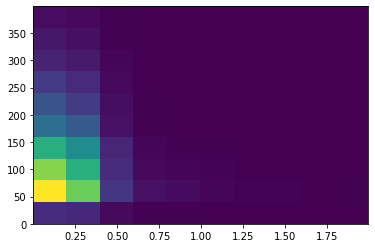

In [24]:
t_data_set=data_set.loc[(data_set.price<400) & (data_set.nearest_subway_station<2)]
heatmap,xedges, yedges=np.histogram2d(t_data_set['nearest_subway_station'], t_data_set['price'],density=True)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

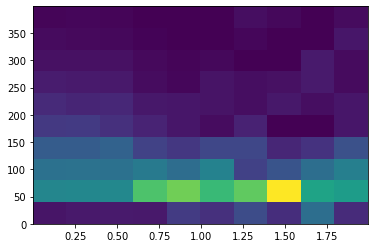

In [25]:
heatmap=(heatmap.T/heatmap.sum(1)).T
#heatmap=(heatmap/heatmap.sum(0))
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

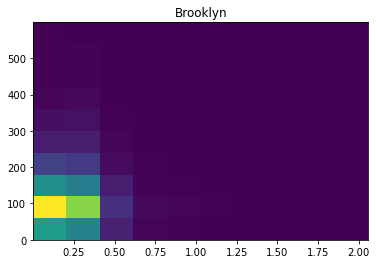

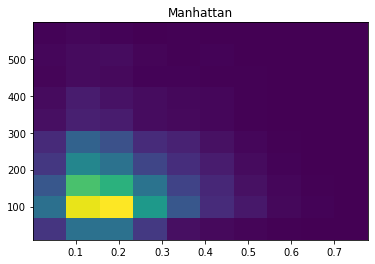

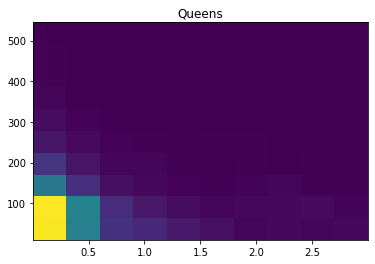

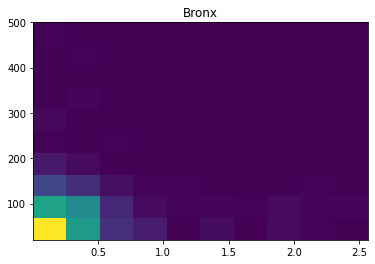

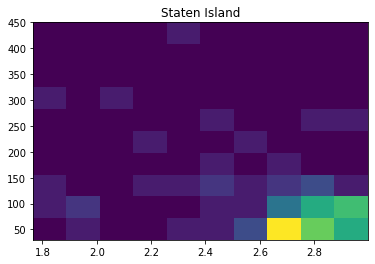

In [35]:
t_data_set=data_set.loc[(data_set.price<600) & (data_set.nearest_subway_station<3)]
for n in t_data_set["neighbourhood_group"].unique():
    tt_data_set=t_data_set.loc[(t_data_set.neighbourhood_group==n)]
    heatmap,xedges, yedges=np.histogram2d(tt_data_set['nearest_subway_station'], tt_data_set['price'],density=True)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #heatmap=(heatmap.T/heatmap.sum(1)).T
    #heatmap=(heatmap/heatmap.sum(0))
    plt.figure()
    plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")
    plt.title(n)

While there is something to be said for the distances to the subway for the different districts, it is rather difficult to pin down what it going on without spatial context. That is, if we visualize by a map, it will become more clear what the association between subway distance and price really is.

Observing the contingency table, normalized for distance ranges so that we are observing the proportion of the locations in each distance range that fall into each price range shown. Interestingly, we observe a trend such that in the lower distance ranges (<.6), there is an enrichment of higher priced proprties not seen at the larger subway distances. The impace of this is that the average price of rentals less than half a mile from a subway station is much higher than those further from stations. However, is the subway factor driving this, or is it that subway stations happen to be where higher priced housing is (i.e Manhattan). To see how subway station distance varies geographically, we will plot the distance to subway station overlayed on a map.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

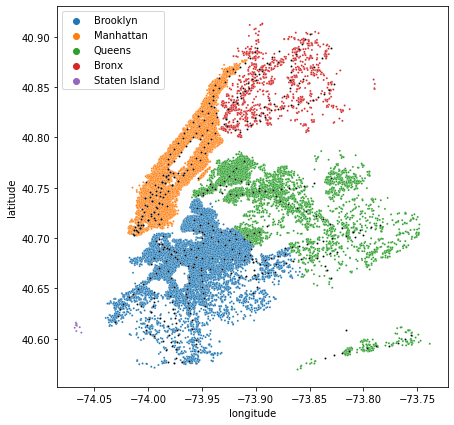

In [385]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

<AxesSubplot:>

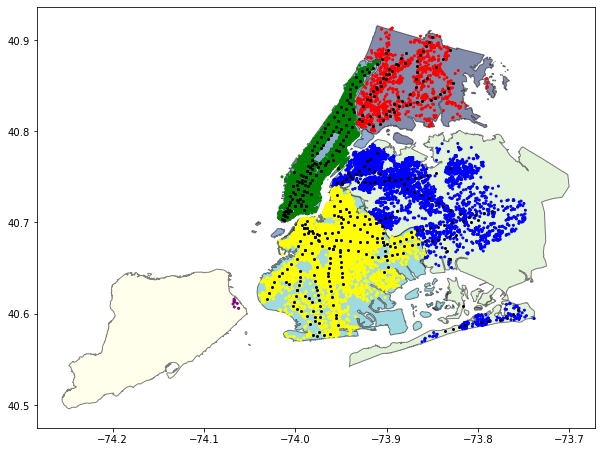

In [403]:
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.to_crs("EPSG:4326").plot(figsize=(10, 10), alpha=0.5, edgecolor='k',cmap='YlGnBu')
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
colors = {'Bronx':'red', 'Manhattan':'green', 'Queens':'blue', 'Brooklyn':'yellow','Staten Island':'purple'}
gdf=gpd.GeoDataFrame(data_set,geometry=geometry,crs='epsg:3857')
gdf.plot(ax=ax,markersize=4,c=gdf.neighbourhood_group.map(colors))
geometry=[Point(x,y) for x,y in zip(eat_fresh.longitude,eat_fresh.latitude)]
sdf=gpd.GeoDataFrame(eat_fresh,geometry=geometry,crs='epsg:3857')
sdf.plot(ax=ax,markersize=4,color='black')
#sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
#sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

<AxesSubplot:>

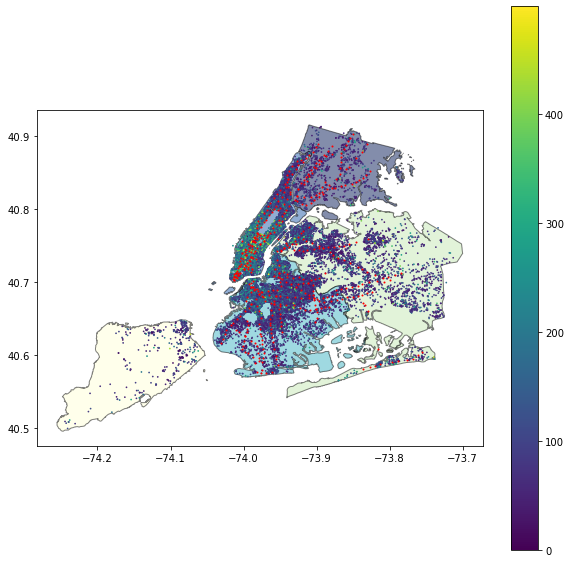

In [415]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set=data_set.loc[(data_set.price<500)]
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.to_crs("EPSG:4326").plot(figsize=(10, 10), alpha=0.5, edgecolor='k',cmap='YlGnBu')
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
colors = {'Bronx':'red', 'Manhattan':'green', 'Queens':'blue', 'Brooklyn':'yellow','Staten Island':'purple'}
gdf=gpd.GeoDataFrame(data_set,geometry=geometry,crs='epsg:3857')
gdf.plot(ax=ax,markersize=.5,column='price',legend=True)#c=gdf.neighbourhood_group.map(colors))
geometry=[Point(x,y) for x,y in zip(eat_fresh.longitude,eat_fresh.latitude)]
sdf=gpd.GeoDataFrame(eat_fresh,geometry=geometry,crs='epsg:3857')
sdf.plot(ax=ax,markersize=1,color='red')
#sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
#sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

This geographic mapping of the properties paints a much clearer picture. Price seems most correlated with distance from Manhattan, and in particular South-central Manhattan. Determining why that is the case is well beyond the scope of this data set, but an adequate explanation would be that that is where the "city" is. We can aslo see that the northwestern part of Brooklyn is pricier as well, whichwe know is a result of the "city" part of Brooklyn being. It is difficult to discern if there is any additional effect of being near a subway, which we thought might be an effect.

<AxesSubplot:>

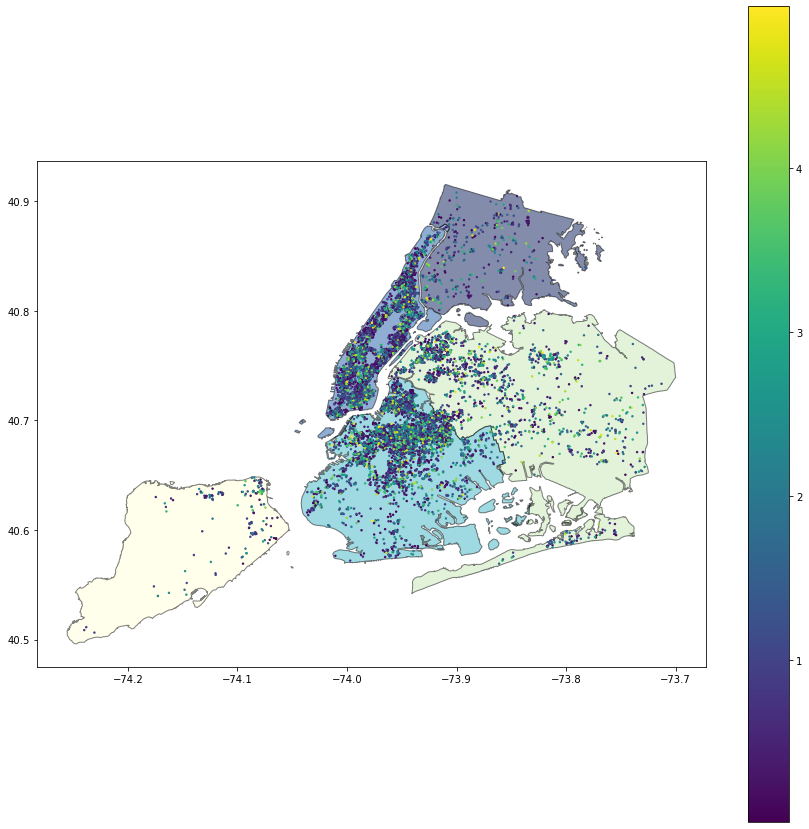

In [428]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set=data_set.loc[data_set.reviews_per_month<5]
data_set=data_set.loc[data_set.availability_365>200]
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.to_crs("EPSG:4326").plot(figsize=(15, 15), alpha=0.5, edgecolor='k',cmap='YlGnBu')
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
colors = {'Bronx':'red', 'Manhattan':'green', 'Queens':'blue', 'Brooklyn':'yellow','Staten Island':'purple'}
gdf=gpd.GeoDataFrame(data_set,geometry=geometry,crs='epsg:3857')
gdf.plot(ax=ax,markersize=2,column='reviews_per_month',legend=True)#c=gdf.neighbourhood_group.map(colors))
#sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
#sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

If we go back to thinking about reviews per month/minimum stay as a proxy for popularity (how often people stay), we can try and see if we can locate "hotspots" for AirBnb stays. Interesting, this doesn't correlate with the proximity to the city areas as price did. Instead, it almost seems as if there is more of a correlation with sparsity. That is, it seems that the areas in which there are less options, more people review. However, it also happens that these areas, if we remember from earlier, are further from the expensive areas. Given that AirBnb's are supposed to be a cheaper experience than hotels, which is part of the allure, could it be that people are just very price sensitive and willing to spend nights further away from the city center for a cheaper rate?

In [427]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set=data_set.loc[data_set.reviews_per_month<50]
data_set=data_set.loc[data_set.neighbourhood_group!="Manhattan"]
data_set=data_set.loc[data_set.availability_365>200]
print(np.cov(data_set.price,data_set.reviews_per_month))

[[ 2.97155234e+04 -1.28213794e+01]
 [-1.28213794e+01  3.04965017e+00]]
[[ 2.97155234e+04 -1.28213794e+01]
 [-1.28213794e+01  3.04965017e+00]]


Clearly there is some negative correllation which validates our previous observation. However,it is a far cry from a strong correlation, so it doesn't completely explain the reviews by any means. One other thing is comfort level provided, in that some apts/houses are just nicer than others. These places might be getting more visits than less nice houses.

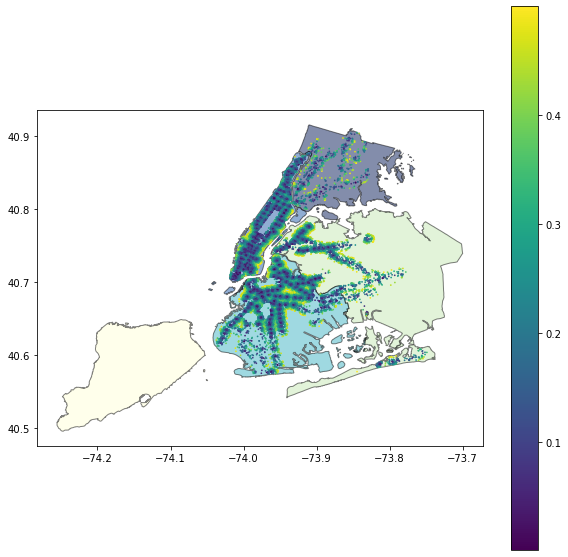

In [433]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set=data_set.loc[data_set.nearest_subway_station<.5]
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.to_crs("EPSG:4326").plot(figsize=(10, 10), alpha=0.5, edgecolor='k',cmap='YlGnBu')
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
colors = {'Bronx':'red', 'Manhattan':'green', 'Queens':'blue', 'Brooklyn':'yellow','Staten Island':'purple'}
gdf=gpd.GeoDataFrame(data_set,geometry=geometry,crs='epsg:3857')
gdf.plot(ax=ax,markersize=.5,column='nearest_subway_station',legend=True)#c=gdf.neighbourhood_group.map(colors))
geometry=[Point(x,y) for x,y in zip(eat_fresh.longitude,eat_fresh.latitude)]
sdf=gpd.GeoDataFrame(eat_fresh,geometry=geometry,crs='epsg:3857')
#sdf.plot(ax=ax,markersize=1,color='red')
#sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
#sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

## Cluster Neighborhoods based on other factors and then plot vs locations (maybe PC1 on geomap?)

In [461]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set.head(100)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Year_Born,gender,decade,nearest_subway_station
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1974.0,male,70s,0.329138
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,1984.0,female,80s,0.078842
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1982.0,female,80s,0.216456
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,NaN,unknown,NaN,0.258979
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1959.0,female,50s,0.107340
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,1958.0,mostly_male,50s,0.340328
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0,1985.0,unknown,80s,0.231601
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220,NaN,male,NaN,0.194199
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0,NaN,unknown,NaN,0.146279
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188,1975.0,male,70s,0.050373


In [436]:
data_set.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Year_Born', 'gender', 'decade',
       'nearest_subway_station', 'geometry'],
      dtype='object')

In [462]:
data_set["shared"]=[1 if apt=="Shared room" else 0 for apt in data_set.room_type]
data_set["private"]=[1 if apt=="Private room" else 0 for apt in data_set.room_type]
data_set["gender"]=[1 if (per=="male" or per=="mostly_male") else 0 for per in data_set.gender]


In [463]:
data_set=data_set[['shared','private','gender','reviews_per_month','number_of_reviews','price','calculated_host_listings_count','minimum_nights']]
data_set=data_set[data_set["number_of_reviews"].notna()]
data_set=data_set[data_set["reviews_per_month"].notna()]

In [465]:
data_set.head(100)

,shared,private,gender,reviews_per_month,number_of_reviews,price,calculated_host_listings_count,minimum_nights
0,-0.155887,1.090893,1.300090,-0.551511,-0.320414,-0.015493,-0.034716,-0.293996
1,-0.155887,-0.916680,-0.769178,-0.445079,0.487665,0.300974,-0.156104,-0.293996
2,-0.155887,1.090893,-0.769178,-0.682986,-0.522433,-0.011329,-0.186451,-0.196484
3,-0.155887,-0.916680,-0.769178,2.221978,5.538156,-0.265335,-0.186451,-0.293996
4,-0.155887,-0.916680,-0.769178,-0.620379,-0.320414,-0.302811,-0.186451,0.144807
5,-0.155887,-0.916680,1.300090,-0.313604,1.138617,0.196873,-0.186451,-0.196484
6,-0.155887,1.090893,-0.769178,-0.432558,0.577451,-0.386092,-0.186451,1.851263
7,-0.155887,1.090893,1.300090,1.489476,9.129616,-0.306975,-0.186451,-0.245240
8,-0.155887,1.090893,-0.769178,-0.063177,2.126269,-0.306975,-0.186451,-0.245240
9,-0.155887,-0.916680,1.300090,0.149687,3.069027,-0.011329,-0.095410,-0.293996


In [464]:
sc=StandardScaler()
data_set[['shared','private','gender','reviews_per_month','number_of_reviews','price','calculated_host_listings_count','minimum_nights']] = sc.fit_transform(data_set[['shared','private','gender','reviews_per_month','number_of_reviews','price','calculated_host_listings_count','minimum_nights']])


In [467]:
pca=PCA(2)
pcs=pca.fit_transform(data_set)

In [473]:
pcs.shape

(48895, 2)

/Users/Ryan/anaconda2/envs/STA160/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

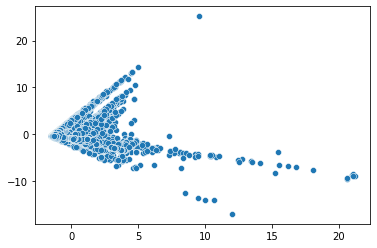

In [477]:
sns.scatterplot(pcs[:,1],pcs[:,0])

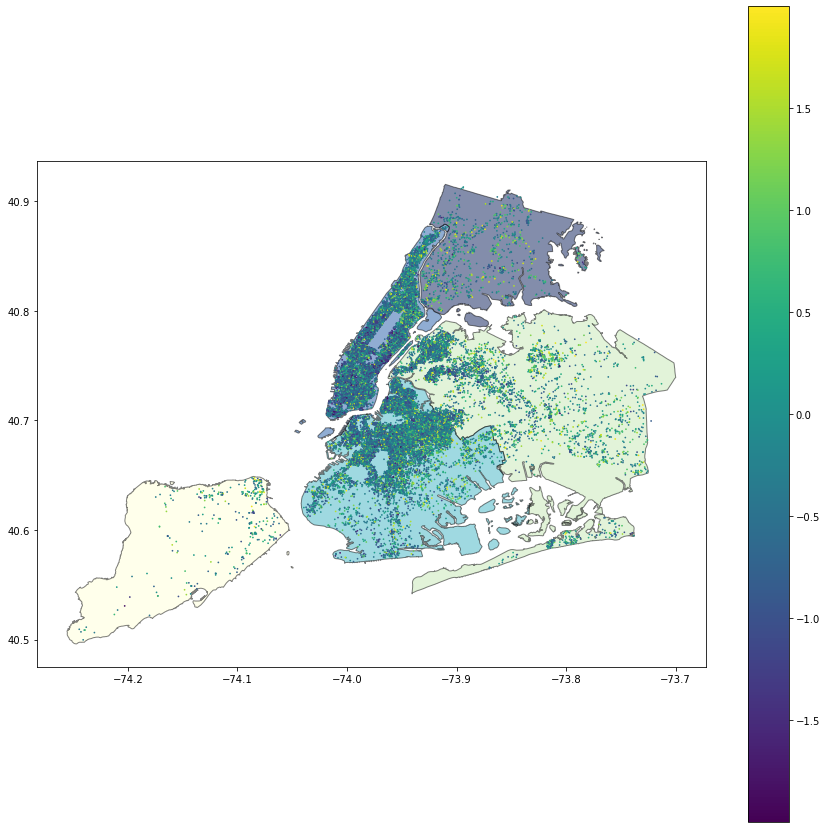

In [481]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
data_set['pc1']=pcs[:,0]
data_set=data_set.loc[(data_set.pc1<2)&(data_set.pc1>-2)]
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
ax = df.to_crs("EPSG:4326").plot(figsize=(15, 15), alpha=0.5, edgecolor='k',cmap='YlGnBu')
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
colors = {'Bronx':'red', 'Manhattan':'green', 'Queens':'blue', 'Brooklyn':'yellow','Staten Island':'purple'}
gdf=gpd.GeoDataFrame(data_set,geometry=geometry,crs='epsg:3857')
gdf.plot(ax=ax,markersize=.5,column='pc1',legend=True)#c=gdf.neighbourhood_group.map(colors))
geometry=[Point(x,y) for x,y in zip(eat_fresh.longitude,eat_fresh.latitude)]
sdf=gpd.GeoDataFrame(eat_fresh,geometry=geometry,crs='epsg:3857')
#sdf.plot(ax=ax,markersize=1,color='red')
#sns.scatterplot(data=data_set,x='longitude',y='latitude',s=4,hue='neighbourhood_group')
#sns.scatterplot(data=eat_fresh,x='longitude',y='latitude',s=4,color='black')

Unsurprisingly, there aren't many obvious clusters with repsect to coordniate location. There does appear to be lower pc1 scores in the nice part of manhattan, and from that we predict that PC1 is negative for price, which we were indeed correct about.

In [489]:
print(pca.transform(np.diag(np.ones(8))))

[[-0.04172044  0.18352265]
 [ 0.18436291 -0.6441819 ]
 [ 0.02132094 -0.05471709]
 [ 0.64066185  0.26694944]
 [ 0.63375901  0.27430394]
 [-0.19018099  0.50660837]
 [-0.2113427   0.32809455]
 [-0.26623769  0.19378448]]
Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Year_Born', 'gender', 'decade',
       'nearest_subway_station', 'pc1', 'geometry'],
      dtype='object')


'shared','private','gender','reviews_per_month','number_of_reviews','price','calculated_host_listings_count','minimum_nights'

We can get a finer resolution by looking at the indiviudal neighbourhoods. Unfortunately, the AirBnB provided neighborhoods do not align with those generally considered in NYC. In particular, NYCopendata provided a map of neighborhoods, but we need to use our coordinates to get the correct neighboorhoods.

In [535]:
data_set=pd.read_csv("Airbnb_NYC_2019.csv")
geometry=[Point(x,y) for x,y in zip(data_set.longitude,data_set.latitude)]
data_set=gpd.GeoDataFrame(data_set,geometry=geometry,crs="EPSG:4326")
neighbourhoods = pd.read_csv('nynta.csv')
geometry=neighbourhoods['the_geom'].apply(wkt.loads)
neighbourhoods = gpd.GeoDataFrame(neighbourhoods, geometry=geometry,crs="EPSG:4326")
data_set = gpd.sjoin(neighbourhoods, data_set, how='inner', op='intersects')

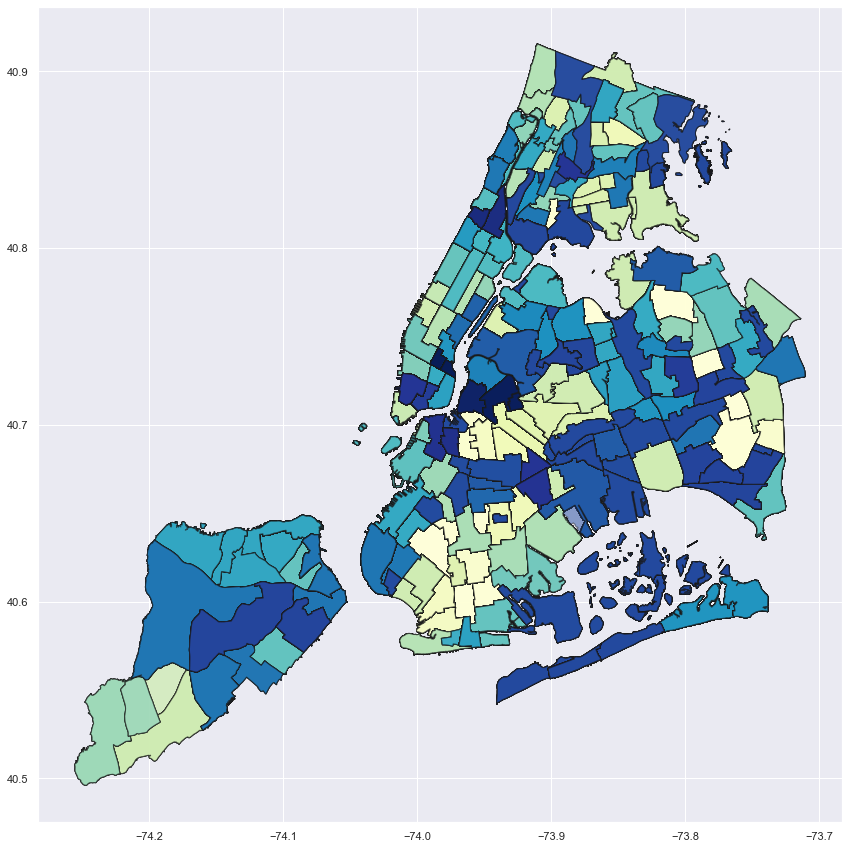

In [195]:
ax = data_set.plot(figsize=(15, 15), alpha=0.5, edgecolor='k',cmap='YlGnBu')


In [179]:
data_set.head(100)

,the_geom,CountyFIPS,BoroCode,BoroName,NTACode,NTAName,Shape_Leng,Shape_Area,geometry,index_right,...,Decade1,Decade2,Decade3,Decade4,Decade5,Decade6,Decade7,Decade8,Decade9,Decade10
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",40039,...,80s,80s,80s,90s,80s,80s,90s,80s,80s,80s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",36156,...,80s,80s,100s,80s,80s,90s,90s,90s,80s,80s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",36356,...,60s,60s,40s,70s,50s,60s,50s,60s,60s,60s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",20140,...,80s,80s,100s,100s,90s,60s,80s,80s,90s,100s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",6626,...,50s,60s,30s,50s,30s,60s,50s,30s,50s,40s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",28543,...,40s,60s,100s,50s,60s,40s,60s,80s,40s,50s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",13627,...,90s,100s,80s,100s,100s,80s,90s,90s,90s,100s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",19188,...,70s,70s,100s,90s,90s,90s,100s,60s,90s,90s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",24246,...,40s,40s,60s,50s,30s,30s,60s,40s,60s,50s
0,MULTIPOLYGON (((-73.97604935657381 40.63127590...,47,3,Brooklyn,BK88,Borough Park,39247.227831,5.400502e+07,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...",25382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
len(d)

102

In [190]:
plt.figure(figsize=(7,7))

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [507]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set.loc[data_set.room_type=="Entire home/apt"]
d=c[["room_type","NTAName","price"]].groupby(["room_type","NTAName"]).count()/counts

d=d.loc[d.price==d.price]
#d

Text(0.5, 1.0, 'Entire Home/Apt Proportion')

<Figure size 504x504 with 0 Axes>

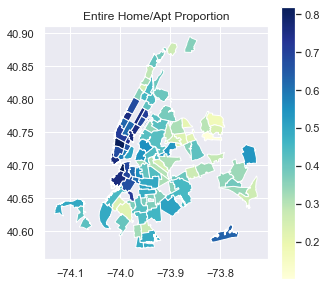

In [508]:
true_count = neighbourhoods.merge(d, on='NTAName')
plt.figure(figsize=(7,7))
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Entire Home/Apt Proportion")

In [455]:
def zero(x):
    if x>0:
        return x
    else:
        return 0

Text(0.5, 1.0, 'Subway Dist vs Price Correlation')

<Figure size 504x720 with 0 Axes>

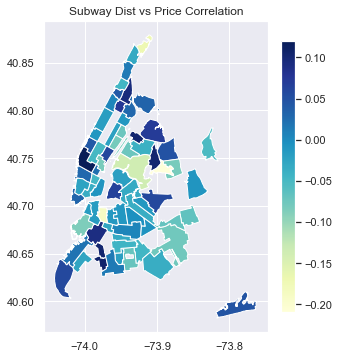

In [541]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>100]
#c=data_set.loc[data_set.room_type=="Private room"]
c=data_set#.loc[data_set.room_type=="Entire home/apt"]
d=c.groupby('NTAName')[['price','nearest_subway_station']].corr().iloc[0::2,-1]
#d=d.loc[d.price==d.price]
d
d = pd.merge(counts, d, how='inner',on='NTAName')
true_count = neighbourhoods.merge(d, on='NTAName')
#true_count['nearest_subway_station']=[zero(x) for x in true_count['nearest_subway_station'].tolist()]
plt.figure(figsize=(7,10))
true_count.plot(column='nearest_subway_station',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Subway Dist vs Price Correlation")

In [ ]:
from sklearn.linear_model import LinearRegression

ln=LinearRegression()

In [450]:
data_set.groupby('NTAName')[['price','nearest_subway_station']].corr().iloc[0::2,-1]

AttributeError: 'Series' object has no attribute 'columns'

First, we observe that the areas of Northern Brooklyn and Southern Manhattan, the citiest parts of NYC, have the highest proportion of Entire home listings. As mentioned above, this makes sense given that these areas likely have a higher proportion of single bedroom residences and as a result more of the posted residences are going to be for full apt.

Text(0.5, 1.0, 'Private Room Proportion')

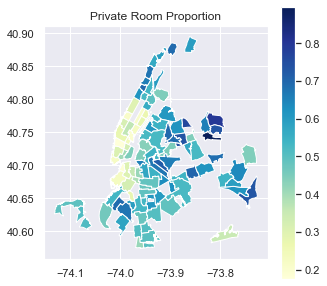

In [510]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set.loc[data_set.room_type=="Private room"]
d=c[["room_type","NTAName","price"]].groupby(["room_type","NTAName"]).count()/counts

d=d.loc[d.price==d.price]
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Private Room Proportion")

Text(0.5, 1.0, 'Shared Room Proportion')

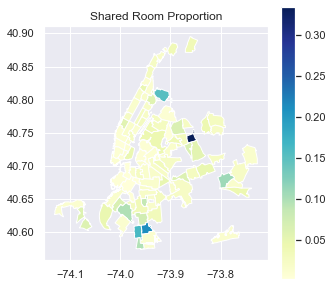

In [511]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set.loc[data_set.room_type=="Shared room"]
d=c[["room_type","NTAName","price"]].groupby(["room_type","NTAName"]).count()/counts

d=d.loc[d.price==d.price]
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Shared Room Proportion")

Text(0.5, 1.0, 'Shared Room Proportion-Unique Host')

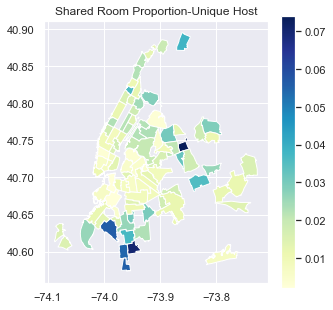

In [512]:
data_set=data_set.drop_duplicates(subset = ["host_id"])
#counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
#counts=counts.loc[counts.price>50]
c=data_set.loc[data_set.room_type=="Shared room"]
d=c[["room_type","NTAName","price"]].groupby(["room_type","NTAName"]).count()/counts

d=d.loc[d.price==d.price]
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Shared Room Proportion-Unique Host")

In looking at the distribution of shared rooms, we are very surprised by the outliers. That is, there are a few neighborhoods with extremely high rates of shared rooms. We decided to look further into one of these regions, Corona.

In [186]:
data_set.columns

Index(['the_geom', 'CountyFIPS', 'BoroCode', 'BoroName', 'NTACode', 'NTAName',
       'Shape_Leng', 'Shape_Area', 'geometry', 'index_right', 'id', 'name',
       'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'gender',
       'nearest_subway_station', 'Age1', 'Age2', 'Age3', 'Age4', 'Age5',
       'Age6', 'Age7', 'Age8', 'Age9', 'Age10', 'Decade1', 'Decade2',
       'Decade3', 'Decade4', 'Decade5', 'Decade6', 'Decade7', 'Decade8',
       'Decade9', 'Decade10'],
      dtype='object')

In [187]:
c=data_set.loc[data_set.NTAName=="Corona"]
print(len(c))
c[['host_name','name','latitude','calculated_host_listings_count', 'longitude','room_type','price','number_of_reviews','last_review','minimum_nights','gender','availability_365']].head(100)

54


,host_name,name,latitude,calculated_host_listings_count,longitude,room_type,price,number_of_reviews,last_review,minimum_nights,gender,availability_365
106,Nonie,PrivateBed&BathLGAMetsTimeSqUSTAFlushingQueens,40.75046,1,-73.85443,Private room,40,19,2019-06-24,2,unknown,24
106,Casa Victoria,Explore NYC From Our Private Studio w/Free Wifi,40.75047,1,-73.85374,Private room,75,26,2019-06-24,1,unknown,115
106,Luis,Lovely Charming and quiet 2 bed apartment,40.75058,6,-73.85350,Entire home/apt,119,37,2019-07-02,2,male,336
106,Celeste,One Bedroom Apt. Private House close to Citi F...,40.75094,1,-73.85244,Entire home/apt,125,16,2017-11-12,1,female,157
106,Luis,La Guardia Airport Cozy Attic studio with Spiral,40.75134,6,-73.85219,Entire home/apt,79,83,2019-07-02,2,male,320
106,Mary,BIENVENIDOS MI CASA ES TU CASA,40.74666,2,-73.85781,Private room,50,6,2019-06-29,1,mostly_female,164
106,Ahmed,AWESOME PRIVATE FAMILY HOUSE CLOSE TO MANHATTAN,40.74725,1,-73.85486,Entire home/apt,359,10,2019-06-09,3,male,281
106,Luffy,BasementSolo Private bedRoom No \nWindow in NY...,40.74736,2,-73.85587,Shared room,27,13,2019-06-21,2,unknown,361
106,Luffy,"LowerLevel House NYC,Traveler ShortStay BedRoom",40.74864,2,-73.85436,Shared room,27,16,2019-06-07,2,unknown,365
106,Jackie,"COMFY & SECURE NEAR AIRPORT, SHOPPING MALLS & ...",40.74332,1,-73.85469,Private room,52,45,2018-08-07,1,andy,57


We can observe by taking a closer look at the data that the shared rooms are being driven by two sets of landlords who each have multiple rentals. The also seam to be catering to the Latino community as well.

Text(0.5, 1.0, 'Mean Average Availability')

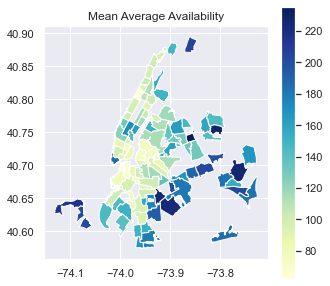

In [516]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set#.loc[data_set.room_type=="Private room"]
d=c[["NTAName","availability_365"]].groupby(["NTAName"]).mean()#/counts*counts

d=d.loc[d.availability_365==d.availability_365]
d
d = pd.merge(counts, d, how='inner',on='NTAName')
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='availability_365',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Mean Average Availability")

<AxesSubplot:>

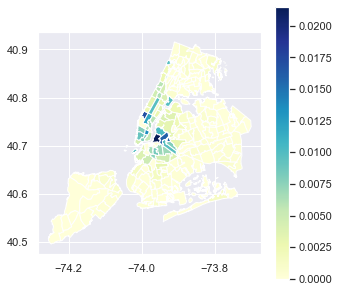

In [212]:
pops=pd.read_csv('NYC_Population_By_Neighborhood_Tabulation_Areas.csv')
pops=pops.loc[pops.Year==2010]
pops=pops[["NTA Name","Population"]]
pops.columns=["NTAName","price"]
pops=pops[["NTAName","price"]].groupby("NTAName").mean()
pops=pops.loc[pops.price>1000]
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
d=c[["price","NTAName"]].groupby(["NTAName"]).count()/pops
d.loc[d.price!=d.price]=0
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')

In [175]:
true_count

,the_geom,CountyFIPS,BoroCode,BoroName,NTACode,NTAName,Shape_Leng,Shape_Area,geometry,30s,40s,50s,60s,70s,80s,90s,100s,clusters
0,MULTIPOLYGON (((-73.75205066516907 40.70522802...,81,4,Queens,QN08,St. Albans,45401.316980,7.741275e+07,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",0.100000,0.125000,0.075000,0.100000,0.100000,0.075000,0.350000,0.075000,4
1,MULTIPOLYGON (((-73.97084113729679 40.64637857...,47,3,Brooklyn,BK41,Kensington-Ocean Parkway,20800.752358,1.589331e+07,"MULTIPOLYGON (((-73.97084 40.64638, -73.97077 ...",0.041237,0.041237,0.092784,0.195876,0.113402,0.154639,0.268041,0.092784,0
2,MULTIPOLYGON (((-73.94826499590911 40.63860718...,47,3,Brooklyn,BK95,Erasmus,18756.702033,1.452260e+07,"MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...",0.083333,0.074074,0.074074,0.157407,0.129630,0.148148,0.194444,0.138889,1
3,MULTIPOLYGON (((-73.95337017508862 40.68064050...,47,3,Brooklyn,BK69,Clinton Hill,23971.466027,2.052820e+07,"MULTIPOLYGON (((-73.95337 40.68064, -73.95328 ...",0.049536,0.063467,0.114551,0.103715,0.151703,0.205882,0.250774,0.060372,0
4,MULTIPOLYGON (((-73.96014773493862 40.62891518...,47,3,Brooklyn,BK43,Midwood,27996.590612,3.579957e+07,"MULTIPOLYGON (((-73.96015 40.62892, -73.95996 ...",0.000000,0.055556,0.148148,0.166667,0.166667,0.148148,0.185185,0.129630,1
5,MULTIPOLYGON (((-73.95023693757913 40.70547324...,47,3,Brooklyn,BK72,Williamsburg,16874.433834,1.158999e+07,"MULTIPOLYGON (((-73.95024 40.70547, -73.94984 ...",0.017857,0.125000,0.071429,0.125000,0.250000,0.160714,0.142857,0.107143,1
6,MULTIPOLYGON (((-73.94193078816188 40.70072523...,47,3,Brooklyn,BK75,Bedford,29992.923800,3.262979e+07,"MULTIPOLYGON (((-73.94193 40.70073, -73.94439 ...",0.064334,0.081264,0.095937,0.154628,0.136569,0.171558,0.213318,0.082393,1
7,MULTIPOLYGON (((-73.91804606892451 40.68721324...,47,3,Brooklyn,BK35,Stuyvesant Heights,28239.080890,3.140694e+07,"MULTIPOLYGON (((-73.91805 40.68721, -73.91800 ...",0.048235,0.076471,0.095294,0.122353,0.150588,0.164706,0.260000,0.082353,0
8,MULTIPOLYGON (((-73.90855790522765 40.65209593...,47,3,Brooklyn,BK96,Rugby-Remsen Village,30957.854237,3.270695e+07,"MULTIPOLYGON (((-73.90856 40.65210, -73.90945 ...",0.055556,0.111111,0.185185,0.129630,0.185185,0.166667,0.166667,0.000000,2
9,MULTIPOLYGON (((-73.92574389425914 40.64001446...,47,3,Brooklyn,BK91,East Flatbush-Farragut,39201.038180,3.436086e+07,"MULTIPOLYGON (((-73.92574 40.64001, -73.92583 ...",0.066667,0.066667,0.120000,0.213333,0.133333,0.146667,0.200000,0.053333,2


<AxesSubplot:>

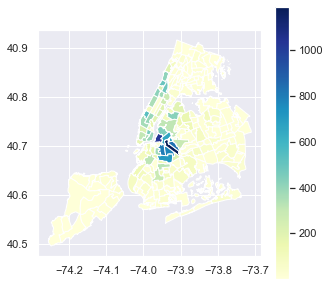

In [207]:
pops=pd.read_csv('NYC_Population_By_Neighborhood_Tabulation_Areas.csv')
pops=pops.loc[pops.Year==2010]
pops=pops[["NTA Name","Population"]]
pops.columns=["NTAName","price"]
pops=pops[["NTAName","price"]].groupby("NTAName").mean()

counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
d=c[["price","NTAName"]].groupby(["NTAName"]).count()
d.loc[d.price!=d.price]=0
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')

Text(0.5, 1.0, 'Price vs Neighborhood')

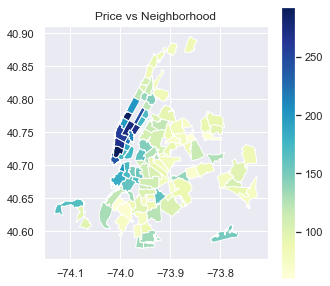

In [292]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set#.loc[data_set.room_type=="Private room"]
d=c[["NTAName","price"]].groupby(["NTAName"]).mean()#/counts*counts

d=d.loc[d.price==d.price]
d = pd.merge(counts, d, how='inner',on='NTAName')
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count
true_count.plot(column='price_y',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Price vs Neighborhood")

Text(0.5, 1.0, 'Average Age of Host')

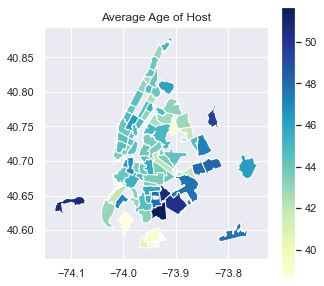

In [432]:
data_set=data_set.drop_duplicates(subset = ["host_id"])
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=data_set#.loc[data_set.room_type=="Private room"]
d=c[["NTAName","Age1","Age3"]].groupby(["NTAName"]).mean()#/counts*counts

d=d.loc[d.Age3==d.Age3]
d = pd.merge(counts, d, how='inner',on='NTAName')
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count
true_count.plot(column='Age1',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Average Age of Host")

The city seems pretty heterogenous age wise, although there does seem to be a really interesting occurence as we get further out from the center of the city. The average age does appear to be increasing in the outer areas. This could definitely be an artifact of the age generation process. However, the broadness of the pattern (in that it is occuring many neighborhoods) does indicate that there is a difference in naming distributions across the city. We will compare one of the younger areas names with the older areas names.

In [112]:
locs=data_set.loc[(data_set.NTAName=="Brighton Beach")|(data_set.NTAName=="Queensboro Hill")]
locs[["NTAName","host_name"]].groupby(["NTAName"]).head(200)

,NTAName,host_name
114,Brighton Beach,Elena
114,Brighton Beach,Al
114,Brighton Beach,Elena
114,Brighton Beach,Michael
114,Brighton Beach,Ella
114,Brighton Beach,Olga
114,Brighton Beach,Elena
114,Brighton Beach,Alex
114,Brighton Beach,Iryna
114,Brighton Beach,Montage Yuriy


It does seem that the data is biased by certain property owners who own multiple listings, there is overall still a pattern of differing names, typically older sounding names, in the Queensboro Hill area. 

In [495]:
data_set=data_set.drop_duplicates(subset = ["host_id"])

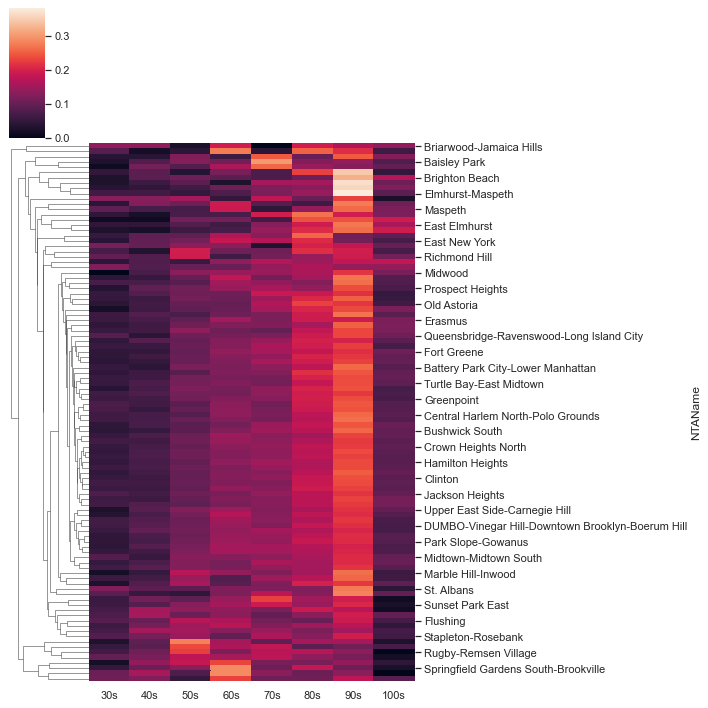

In [304]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=pd.crosstab(data_set.NTAName,data_set.Decade1,normalize="index")
c = pd.merge(counts, c, how='inner',on='NTAName')
hund=c["100s"]
c=c.drop(columns=['price','100s'])
c["100s"]=hund

sns.set(rc={'figure.figsize':(5,100)})
sns.clustermap(c,col_cluster=False)

In [498]:
def swap(x):
        if x==0:
            return 1
        else:
            return 0

def assign(x):
        if x>=7:
            return "1"
        elif x<=3:
            return "0"
        else:
            return "?"

0


Text(0.5, 1.0, 'Clustering By Age Distribution Robustness Check')

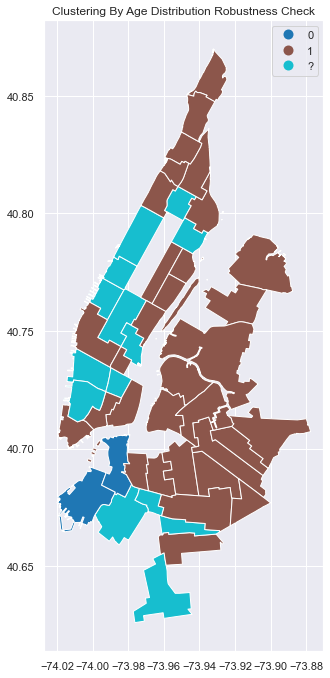

In [502]:
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>200]
tot=[]
for i in range(1,11):
    c=pd.crosstab(data_set.NTAName,data_set[f"Decade{i}"],normalize="index")
    c = pd.merge(counts, c, how='inner',on='NTAName')
    hund=c["100s"]
    c=c.drop(columns=['price','100s'])
    c["100s"]=hund
    c.sort_values('NTAName')
    cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
    c['clusters']=[d for d in cluster.fit_predict(c)]
    if sum(c.clusters.tolist())/len(c.clusters.tolist())<0.5:
        c['clusters']=[swap(x) for x in c.clusters.tolist()]
    
    
    #plt.figure(figsize=(20,10))
    #plot_dendrogram(cluster)
    true_count = neighbourhoods.merge(c, on='NTAName')
    #true_count.plot(column='clusters',legend=True)
    #print(true_count.head())

    tot.append(true_count['clusters'].tolist())
    true_count['clusters']=[str(d) for d in true_count.clusters.tolist()]
true_count.sort_values('NTAName')
#print(true_count.head())
print(tot[6][37])
#true_count['clusters']=np.array(tot).sum(0).tolist()
true_count['clusters']=[assign(x) for x in np.array(tot).sum(0).tolist()]
true_count['clusters'][37]
true_count.plot(column='clusters',legend=True)
plt.title("Clustering By Age Distribution Robustness Check")


In [ ]:
### def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<AxesSubplot:>

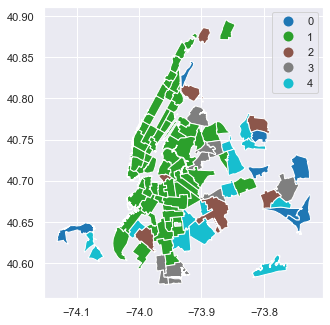

In [306]:
true_count = neighbourhoods.merge(c, on='NTAName')
true_count.plot(column='clusters',legend=True)

This plot, and the above clustermap, reveal that the age distributions across the city are generally consistent, but this does help us quantify what we are seeing where there seem to be different names in the outskirts of the city. Unfortunately, the naming patterns in the outskirts do not cluster as well as we might like, but the fact that only the main cluster appears in downtown NYC and Brooklyn informs us that there is an inherent difference between those areas and the outskirts. The fact that this is still occuring even when we control for duplicate hosts informs us that there are other factors at play. Ethnicities could be a driving factors since our data assumes no immigration, but if this was the case, we might expect to see younger hosts outside the city, since ethnicities with higher recent immigration will have their traditional names appear more often in recent times.

Text(0.5, 1.0, 'Proportion Male vs Location')

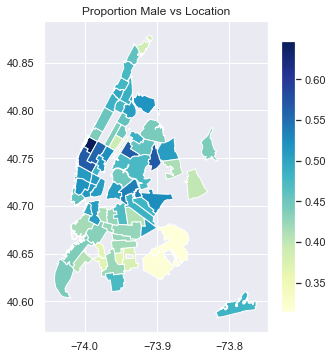

In [295]:
t_data_set=data_set.loc[(data_set.gender!="andy") & (data_set.gender!="unknown")]
counts=t_data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
c=t_data_set.loc[(t_data_set.gender=="male") | (t_data_set.gender=="mostly_male")]
d=c[["NTAName","price"]].groupby("NTAName").count()/counts

d=d.loc[d.price==d.price]
d
true_count = neighbourhoods.merge(d, on='NTAName')
true_count.plot(column='price',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')
plt.title("Proportion Male vs Location")

<AxesSubplot:>

<Figure size 1080x1080 with 0 Axes>

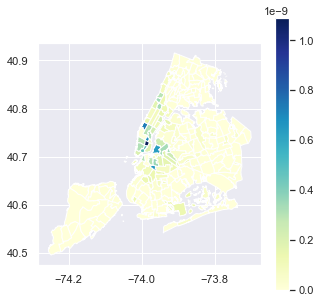

In [230]:
pops=pd.read_csv('NYC_Population_By_Neighborhood_Tabulation_Areas.csv')
pops=pops.loc[pops.Year==2010]
pops=pops[["NTA Name","Population"]]
pops.columns=["NTAName","price"]
pops=pops[["NTAName","price"]].groupby("NTAName").mean()
#pops=pops.loc[pops.price>1000]
counts=data_set[["NTAName","price"]].groupby(["NTAName"]).count()
counts=counts.loc[counts.price>50]
d=c[["price","NTAName"]].groupby(["NTAName"]).count()/pops
d.loc[d.price!=d.price]=0
true_count = neighbourhoods.merge(d, on='NTAName')
true_count['density']=true_count.price/true_count.Shape_Area
plt.figure(figsize=(15,15))
true_count.plot(column='density',legend=True, legend_kwds={'shrink': 0.05},cmap='YlGnBu')


In [228]:
pops.head(200)

,price
NTAName,
Airport,0
Allerton-Pelham Gardens,28903
Annadale-Huguenot-Prince's Bay-Eltingville,27770
Arden Heights,25238
Astoria,78793
Auburndale,19996
Baisley Park,34603
Bath Beach,29931
Battery Park City-Lower Manhattan,39699
